In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd 
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

In [32]:
df = pd.read_csv("Aviation_KPIs_Dataset.xlsx - Sheet1.csv")

In [35]:
# Drop columns that cause data leakage or are irrelevant
drop_columns = [
    "Net Profit Margin (%)", "Revenue per ASK", "Cost per ASK",  # Leakage
    "Flight Number",  # Irrelevant categorical feature
]

In [37]:
df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns], errors="ignore")

In [39]:
# Convert datetime features if they exist
if "Scheduled Departure Time" in df_cleaned.columns and "Actual Departure Time" in df_cleaned.columns:
    df_cleaned["Scheduled Hour"] = pd.to_datetime(df_cleaned["Scheduled Departure Time"]).dt.hour
    df_cleaned["Actual Hour"] = pd.to_datetime(df_cleaned["Actual Departure Time"]).dt.hour
    df_cleaned["Departure Delay"] = df_cleaned["Actual Hour"] - df_cleaned["Scheduled Hour"]
    df_cleaned.drop(columns=["Scheduled Departure Time", "Actual Departure Time"], inplace=True)

In [41]:
# Handle categorical data
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

In [43]:
# Split dataset into features and target variable
target_col = "Profit (USD)"  # Assuming this is the target column
X = df_cleaned.drop(columns=[target_col], errors="ignore")
y = df_cleaned[target_col]

In [45]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=42, n_jobs = 1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

In [51]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [53]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [55]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}\n")
    # print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.4f}\n")
    # print(f"Precision Score: {presicion_score(y_true, y_pred):.4f}\n")

# Performance metrics
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")
evaluate_model(y_test, y_pred_xgb, "XGBoost Regressor")

Linear Regression Performance:
MAE: 0.00
MSE: 0.00
RMSE: 0.00
R² Score: 1.0000

Random Forest Regressor Performance:
MAE: 7186.17
MSE: 77033114.88
RMSE: 8776.85
R² Score: 0.7638

XGBoost Regressor Performance:
MAE: 133.27
MSE: 28502.97
RMSE: 168.83
R² Score: 0.9999



100%|===================| 39981/40000 [05:31<00:00]        

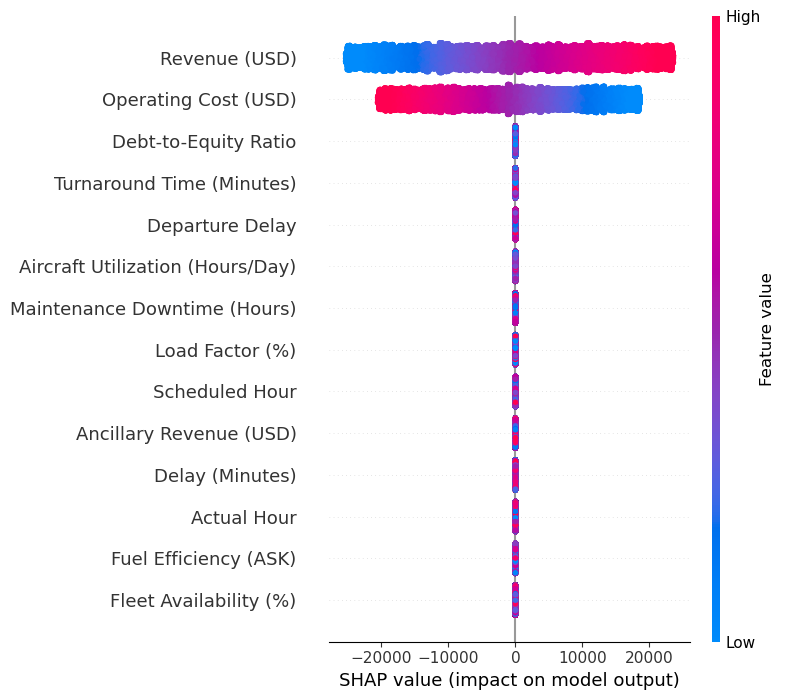

In [57]:
# SHAP Explainability Plot
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [63]:
# Check for overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"\n {model_name} Overfitting Check:")
    print(f"  Training R² Score: {train_score:.4f}")
    print(f"  Testing R² Score: {test_score:.4f}")

    if train_score > 0.95 and (train_score - test_score) > 0.05:
        print("  Possible Overfitting! (High train score, lower test score)")
    elif train_score < 0.85 and test_score < 0.85:
        print("  Possible Underfitting! (Both scores are low)")
    else:
        print("   Model is well-balanced.\n")

    return {"Train R²": train_score, "Test R²": test_score}

rf_overfit = check_overfitting(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")
lr_overfit = check_overfitting(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, "Linear Regression")


 Random Forest Overfitting Check:
  Training R² Score: 0.7638
  Testing R² Score: 0.7638
  Possible Underfitting! (Both scores are low)

 Linear Regression Overfitting Check:
  Training R² Score: 1.0000
  Testing R² Score: 1.0000
   Model is well-balanced.

